In [1]:
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import random 
import json

from matplotlib import pyplot as plt
from sklearn import svm

from src.utils import set_random_seeds

In [2]:
%matplotlib inline

In [3]:
set_random_seeds(65)

# Compute SVM Baseline
## Experiment - Wasserstein distance captures total daset bias
### CelebA

In [4]:
# paths 
attributes = ["Wearing_Necktie", "Eyeglasses", "Wearing_Hat", "Smiling"]

celebA_csv = "../data/celeba/list_attr_celeba.csv"
uniform_csv = "../data/celeba/experiment1_uniform_sample.csv"
biased_csvs = dict()
dataframes = dict()
for attr in attributes:
    biased_csvs[attr] = ["../data/celeba/experiment1_biased_sample_{}_{}.csv".format(attr, n) for n in [10,30,60,90]]
    dataframes[attr] = [pd.read_csv(biased_csvs[attr][i]) for i in range(4)]

In [5]:
# read datatframe of the uniform sample
unif_df = pd.read_csv(uniform_csv)

In [6]:
# read results of the computation of Wasserstein distance stored in a .tsv
wasserstein_df = pd.read_csv("../results/experiment1/wasserstein.tsv", sep= "\t", header=None)
wasserstein_df.columns = ["X", "Y", "features", "wasserstein"]

wasserstein_df.head()

,X,Y,features,wasserstein
0,../data/celeba/experiment1_biased_sample_Weari...,../data/celeba/experiment1_uniform_sample.csv,resnet18,2.894086
1,../data/celeba/experiment1_biased_sample_Weari...,../data/celeba/experiment1_uniform_sample.csv,resnet18,7.785245
2,../data/celeba/experiment1_biased_sample_Weari...,../data/celeba/experiment1_uniform_sample.csv,resnet18,18.817941
3,../data/celeba/experiment1_biased_sample_Weari...,../data/celeba/experiment1_uniform_sample.csv,resnet18,34.127332
4,../data/celeba/experiment1_biased_sample_Weari...,../data/celeba/experiment1_uniform_sample.csv,resnet18,34.127332


In [7]:
def extract_attribute(file, attributes):
    """
    Utility function to extract the attributes 
    from a file name. 
    """
    for attr in attributes:
        if attr in file:
            return attr

# extract the attribute name from the file name stored in the column "X"
wasserstein_df["attr"] = wasserstein_df["X"].apply(lambda x: extract_attribute(x, attributes))
wasserstein_df.drop_duplicates(inplace=True)

wasserstein_df.head()

,X,Y,features,wasserstein,attr
0,../data/celeba/experiment1_biased_sample_Weari...,../data/celeba/experiment1_uniform_sample.csv,resnet18,2.894086,Wearing_Hat
1,../data/celeba/experiment1_biased_sample_Weari...,../data/celeba/experiment1_uniform_sample.csv,resnet18,7.785245,Wearing_Hat
2,../data/celeba/experiment1_biased_sample_Weari...,../data/celeba/experiment1_uniform_sample.csv,resnet18,18.817941,Wearing_Hat
3,../data/celeba/experiment1_biased_sample_Weari...,../data/celeba/experiment1_uniform_sample.csv,resnet18,34.127332,Wearing_Hat
5,../data/celeba/experiment1_biased_sample_Weari...,../data/celeba/experiment1_uniform_sample.csv,resnet18,2.647499,Wearing_Necktie


In [8]:
wasserstein = {attr: list(wasserstein_df[wasserstein_df["attr"] == attr].wasserstein)\
               for attr in attributes}

print("Results of the computation of the Wasserstein distance:\n")
wasserstein.keys()

Results of the computation of the Wasserstein distance:



dict_keys(['Wearing_Necktie', 'Eyeglasses', 'Wearing_Hat', 'Smiling'])

In [9]:
distances = dict()
decision_functions = dict()
accuracy = dict()

# load embedded vectors for the uniform space
space_unif = [torch.load("../data/celeba/resnet18/" + file[:-4] + ".pt").detach().numpy()\
         for file in unif_df["image_id"]]

for attr in attributes:
    distances[attr] = dict()
    decision_functions[attr] = dict()
    accuracy[attr] = dict()
    
    for j in range(4):
        n = [10,30,60,90][j]
        
        dataframes[attr][j]["biased"] = 1
        unif_df["biased"] = -1
        
        space = [torch.load("../data/celeba/resnet18/" + file[:-4] + ".pt").detach().numpy()\
                 for file in dataframes[attr][j]["image_id"]] + space_unif
        
        concat = pd.concat([dataframes[attr][j], unif_df])
        y = concat["biased"]

        X = np.concatenate(space)
        y = np.array(y)
        
        # define the classifier
        classifier = svm.SVC(C=.01, kernel="linear", decision_function_shape="ovo")
        
        # train the classifier
        classifier.fit(X, y)
        distances[attr][n] = (.5*(classifier.decision_function(X)/np.linalg.norm(classifier.coef_))**2).mean()
        accuracy[attr][n] = classifier.score(X, y)
        
        df = concat[concat["biased"] == 1].copy()
        df["Distance"] = classifier.decision_function(X[y == 1])/np.linalg.norm(classifier.coef_)
        decision_functions[attr][n] = df

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


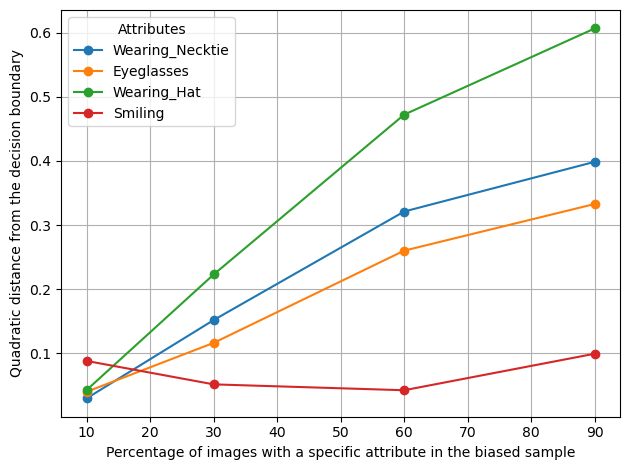

In [10]:
# plot the results
for  i, item in enumerate(distances.items()):
    
    attr, score_dict = item

    scores = [s for n, s in score_dict.items()]
    c = ["tab:blue", "tab:orange", "tab:green", "tab:red"][i]
    plt.plot([10,30,60,90], scores, "-o", c=c)

plt.title("")
plt.xlabel("Percentage of images with a specific attribute in the biased sample")
plt.ylabel("Quadratic distance from the decision boundary")
plt.legend(wasserstein.keys(), title="Attributes")
plt.grid()

plt.tight_layout()
plt.savefig("../results/Experiment1/Distances_plot_2.eps", format ="eps")
plt.show()

### Biased MNIST

In [11]:
# load embedded vectors for the test space
space_test = [torch.load("../data/biased_mnist/resnet18_features/full/test/" + str(i) + ".pt").detach().numpy()\
         for i in range(10000)]

#load train set indices
with open("../data/biased_mnist/train_ixs.json", "r") as file:
    indices = json.load(file)

scores = list()
distances_mnist = dict()
#decision_functions_mnist = dict()

for bias in ["0.1", "0.5", "0.75", "0.9", "0.95", "0.99"]:
    distances_mnist[bias] = list()
    space = [
        torch.load("../data/biased_mnist/resnet18_features/full_{}/trainval/{}.pt"
                   .format(bias, str(i))).detach().numpy()\
        for i in indices] + space_test
        
    X = np.concatenate(space)
    y = np.concatenate([np.ones(50000), np.zeros(10000)])
        
    # define the classifier
    classifier = svm.SVC(C=.01, kernel="linear", decision_function_shape="ovo")
        
    # train the classifier
    classifier.fit(X, y)
    scores.append( (.5*(classifier.decision_function(X)/np.linalg.norm(classifier.coef_))**2).mean() )
        
    distances_mnist[bias].append( classifier.decision_function(X[y == 1])/np.linalg.norm(classifier.coef_) )

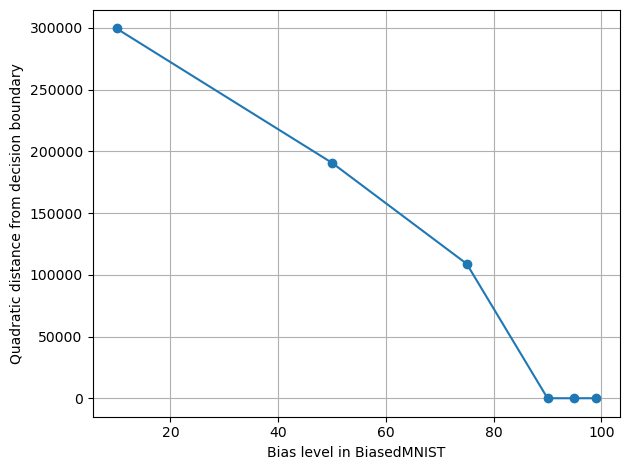

In [12]:
# plot of the results 
plt.plot([10, 50, 75, 90, 95, 99], list(scores), "-o")

plt.title("")
plt.xlabel("Bias level in BiasedMNIST")
plt.ylabel("Quadratic distance from decision boundary")
plt.grid()

plt.tight_layout()
plt.savefig("../results/Experiment1/SVM_plot_mnist.eps", format="eps")
plt.show()

In [14]:
scores

[299597.3804474453,
 190730.60116058926,
 108909.0547003813,
 0.09333212910102129,
 0.08432268639155863,
 0.07378532067555503]

In [15]:
classifier.decision_function(X)

array([ 2.81924107,  1.55832607,  2.27007683, ...,  0.60215007,
       -4.92821522, -1.40684301])